<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Визуализация-временного-ряда" data-toc-modified-id="Визуализация-временного-ряда-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Визуализация временного ряда</a></span></li><li><span><a href="#Декомпозиция" data-toc-modified-id="Декомпозиция-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Декомпозиция</a></span></li><li><span><a href="#Количество-заказов-по-периодам" data-toc-modified-id="Количество-заказов-по-периодам-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Количество заказов по периодам</a></span></li><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель исследования:** Построить модель для предсказания количества заказов такси на следующий час.  

**План исследования:**  
- Загрузка и первичный обзор данных;  
- Анализ:
  - Визуализация временного ряда;
  - Декомпозиция (выяление тренда и сезонности)
  - Расчет количества заказов по месяцам/дням недели/часам;
- Обучение моделей:
  - Подготовка данных (автокорреляционный анализ, добавление дополнительных признаков,разделение на train/test);  
  - Подбор гиперпараметров, обучение и оченка качества моделей:
    - Линейная регрессия;  
    - LightGBM;
    - CatBoost;  
  - Определение оптимальной модели;
- Тестирование полученной модели.

## Подготовка

In [ ]:
!pip install catboost -q
!pip install scikit-learn==1.5.2 -q
!pip install matplotlib==3.5.1 -q

In [ ]:
import warnings
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.model_selection import (train_test_split,
                                     TimeSeriesSplit,
                                     cross_val_score,
                                     RandomizedSearchCV)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')

Загрузим датасет и выведем основную информацию

In [ ]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [ ]:
display(df.head(5))
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Ресемплируем данные по одному часу

In [ ]:
df = df.resample('1H').sum()

In [ ]:
display(df.head(5))
display(df.tail(5))
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Проверим данные на наличие пропусков

In [ ]:
print(f'Количество пропущенных значений в целевом признаке: {df["num_orders"].isna().sum()}')

Количество пропущенных значений в целевом признаке: 0


## Анализ

### Визуализация временного ряда

Для начала визуализируем  график временного ряда со скользящим средним

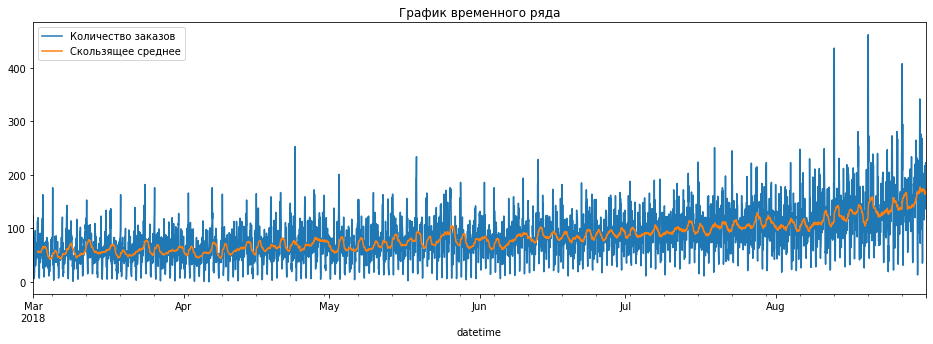

In [ ]:
pd.DataFrame({'Количество заказов': df['num_orders'],
              'Скользящее среднее': df['num_orders'].rolling(24).mean()}).plot(figsize=(16,5))
plt.title('График временного ряда');

Можно отметить тенденцию к постепенному росту количества заказов такси, также наблюдается увеличение разброса значений в августе, что может быть обусловлено резким увеличением количества прибывающих в аэропорт людей всвязи с возвращением из отпуска.  
Выделим тренд, сезонную составляющую и остатки и определим функцию для их визуализации.

### Декомпозиция

In [ ]:
def decomposed_time_series(df):
    decomposed = seasonal_decompose(df)

    plt.figure(figsize=(15, 12))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca(), grid=True)
    plt.title('Тренд')
    plt.xlabel('Период')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca(), grid=True)
    plt.title('Сезонность')
    plt.xlabel('Период')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca(), grid=True)
    plt.title('Остатки')
    plt.xlabel('Период')
    plt.tight_layout()

Визуализируем полученные графики

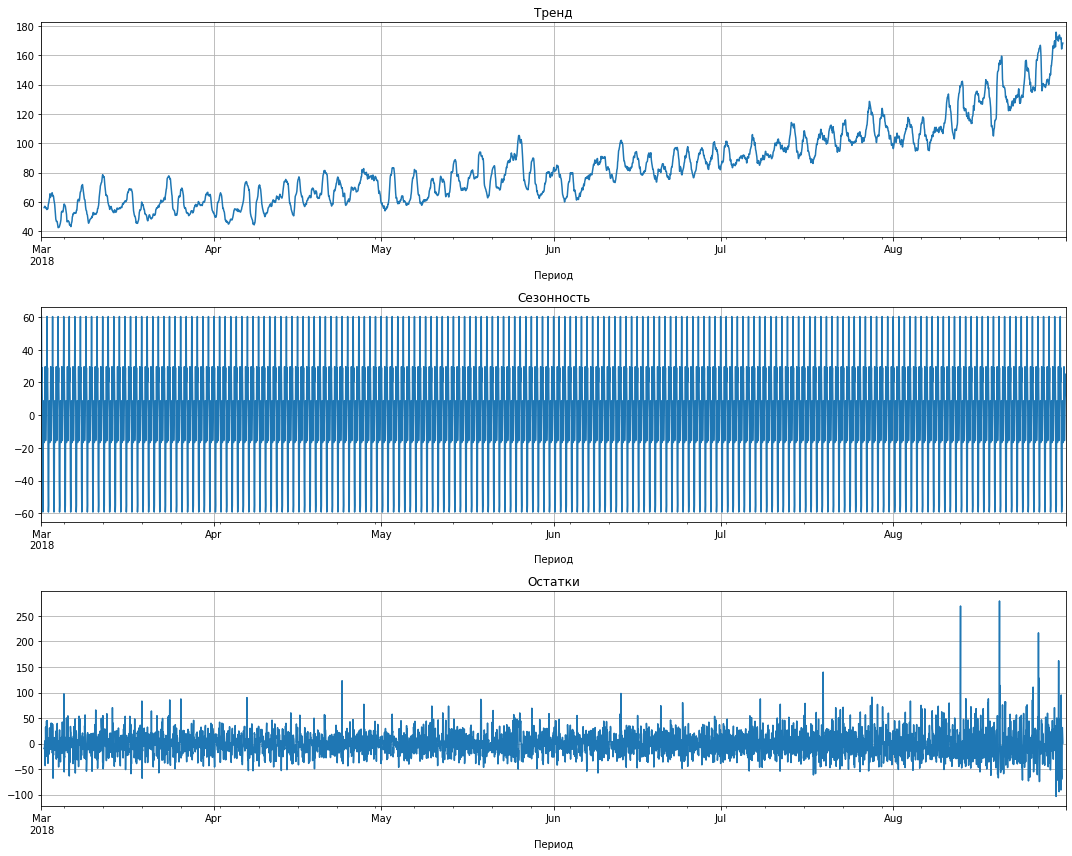

In [ ]:
decomposed_time_series(df)

На полученном графике можно лучше проследить тренд на увеличение количества заказов такси к началу сентября. Однако сложно делать выводы о сезонности, изменим масштаб, построив графики для числа заказов за август.

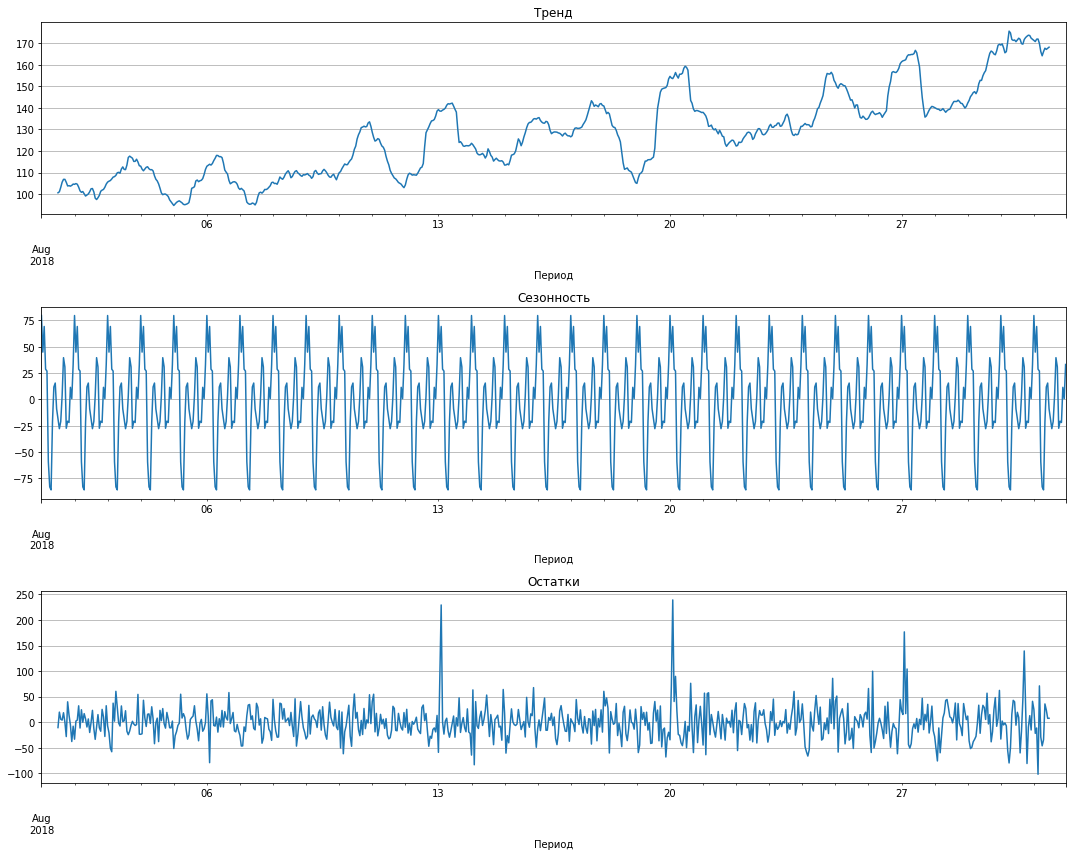

In [ ]:
decomposed_time_series(df['2018-08-01':'2018-08-31'])

Отчётливо видно суточную сезонность, но тобы детальнее рассмотреть, как меняется количество заказов такси в течение суток, расммотрим данные за последние 5 дней месяца

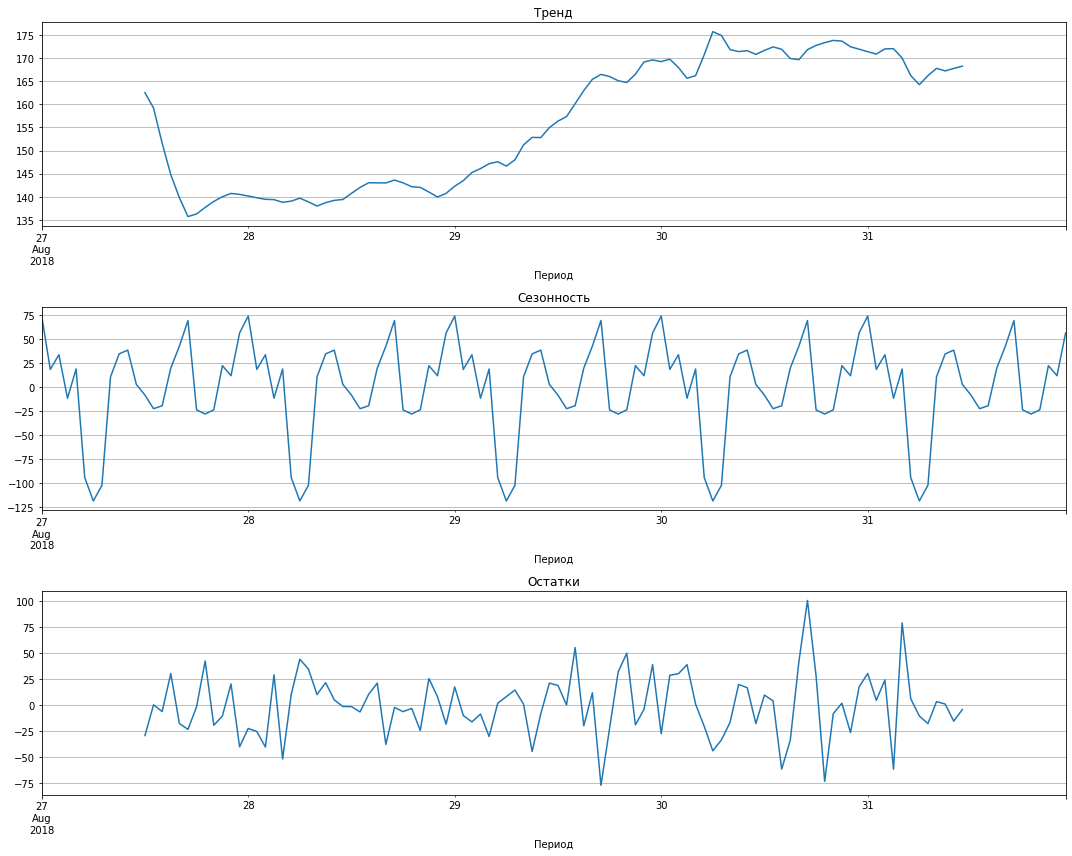

In [ ]:
decomposed_time_series(df['2018-08-27'::])

Вечером и ночью наблюдаются периоды высокой клиентской активности, а ранним утром напротив - наблюдается наиболее сильное сокращение количества заказов.

### Количество заказов по периодам

Рассмотрим как меняется количество заказов по месяцам, дням недели и часам. Для этого выделим соответствующие переменные

In [ ]:
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour

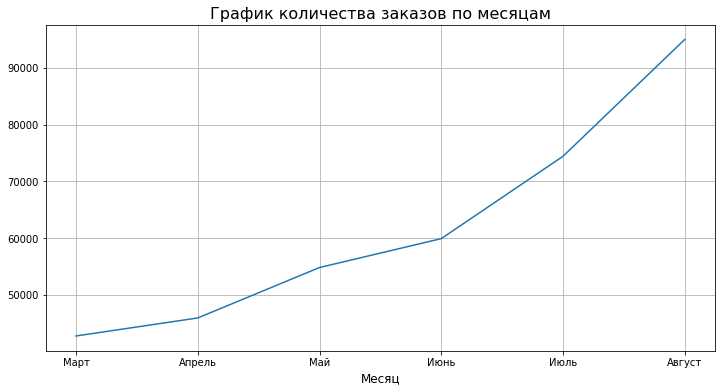

In [ ]:
df.groupby('month')['num_orders'].sum().plot(figsize=(12,6), grid=True)
plt.title('График количества заказов по месяцам', fontsize=16)
plt.xlabel('Месяц', fontsize=12)
plt.xticks(ticks=range(3, 9), labels=['Март',
                                   'Апрель',
                                   'Май',
                                   'Июнь',
                                   'Июль',
                                   'Август']);

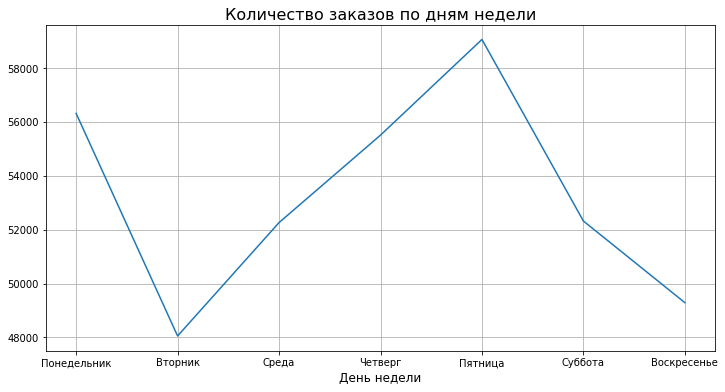

In [ ]:
df.groupby('day_of_week')['num_orders'].sum().plot(figsize=(12,6), grid=True)
plt.title('Количество заказов по дням недели', fontsize=16)
plt.xlabel('День недели', fontsize=12)
plt.xticks(ticks=range(7), labels=['Понедельник',
                                   'Вторник',
                                   'Среда',
                                   'Четверг',
                                   'Пятница',
                                   'Суббота',
                                   'Воскресенье']);

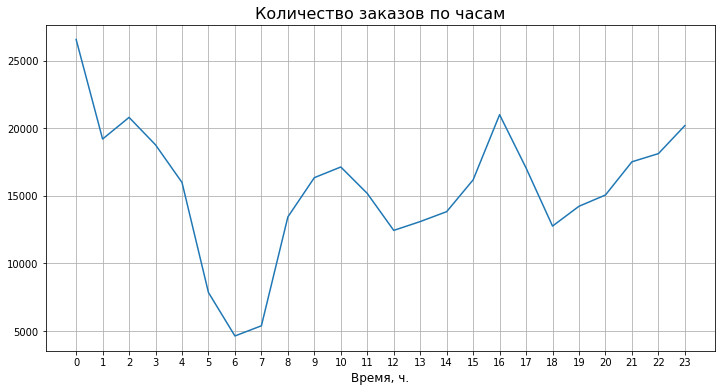

In [ ]:
df.groupby('hour')['num_orders'].sum().plot(figsize=(12,6), grid=True)
plt.title('Количество заказов по часам', fontsize=16)
plt.xlabel('Время, ч.', fontsize=12)
plt.xticks(ticks=range(24));

Как и было отмечено ранее, наибольшее количество заказов регистрируется в августе, причем ближе к концу месяца;  
Пик спроса отмечается в пятницу, далее идёт на снижение и достигает нижней точки во вторник;  
Минимальный спрос - в 06:00, а наибольшее количество заказов приходится на периоды с 22:00 до 03:00, а также с 15:00 до 17:00. Вероятно, в это время прибывает бОльшее количество рейсов.

### Промежуточный вывод

В нашем распоряжении данные о количестве заказов такси в аэропорте с 1 марта по 31 августа включительно. В ходе анализа была выявлена ярко выраженная суточная сезонность: пик количества заказов приходится на ночь, также такси пользуется спросом в вечернее время, а ранним утром напротив - минимальный спрос. Также, очевидно увеличение количество заказов такси к концу лета, наиболее часто вызывают такси в пятницу, и гораздо реже - во вторник.

## Обучение

### Подготовка данных

Прежде чем обучать модели, необходимо создать дополнительные признаки для скользящего среднего и лагов

In [ ]:
def make_features(df, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    df.dropna(inplace=True)

    return df

А чтобы определить максимальное количество лагов, построим автокорреляционную функцию. Так как ярко выражена суточная сезонность, визуализируем функцию для 24 лагов. Однако учитывая, что есть некоторые различия в спросе и по дням недели, выведем также функцию для недельного периода.

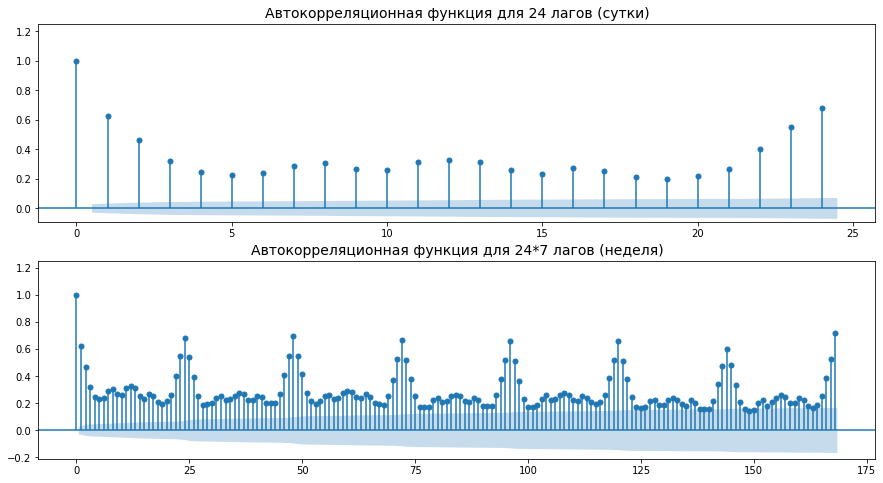

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))

plot_acf(df['num_orders'], ax=ax[0], lags=24, auto_ylims=True)
ax[0].set_title('Автокорреляционная функция для 24 лагов (сутки)', fontsize=14)

plot_acf(df['num_orders'], ax=ax[1], lags=168, auto_ylims=True)
ax[1].set_title('Автокорреляционная функция для 24*7 лагов (неделя)', fontsize=14)
plt.show();

Коэффициенты корреляции превышают пороговые значения, как для 24 лагов, так и для 168 (недельный период), поэтому создадим 168 дполнительных признаков для лагов и попробуем обучить различные модели на полученном наборе данных.

In [ ]:
df_model = make_features(df, 168, 10)

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4080 entries, 2018-03-15 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 174 entries, num_orders to rolling_mean
dtypes: float64(169), int64(5)
memory usage: 5.4 MB


Сначала выделим целевой и входные признаки и разделим данные на обучающую и тестовую выборку в соотношении 9:1, укажем аргумент `shuffle=False`, чтобы при разделении наблюдения не перемешвались.

In [ ]:
RANDOM_STATE=42

X = df_model.drop(columns='num_orders')
y = df_model['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   shuffle=False,
                                                   test_size=0.1,
                                                   random_state=RANDOM_STATE)

### Линейная регрессия

Инициализируем модель линейной регрессии, обучим её и сохраним время обучения

In [ ]:
lr = LinearRegression()

In [ ]:
start = time()

lr.fit(X_train, y_train)

end = time()
lr_fit_time = (end - start)

Посчитаем RMSE на кросс-валидации, выведем результаты (применим TimeSeriesSplit для соблюдения хронологического порядка наблюдений при разделении)

In [ ]:
scores = cross_val_score(
    lr,
    X_train,
    y_train,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

lr_cv_rmse = (-1) * sum(scores) / len(scores)

print('Время обучения модели:', round(lr_fit_time, 4))
print('RMSE на кросс-валидации :', round(lr_cv_rmse, 2))

Время обучения модели: 0.2932
RMSE на кросс-валидации : 22.75


Выполним предсказание на тренировочной выборке, чтобы не "показывать" модели тестовую выборку

In [ ]:
start = time()

y_pred_lr = lr.predict(X_train)

end = time()
lr_predict_time = (end - start)

In [ ]:
print('Время предсказания модели:', round(lr_predict_time, 4))
print('RMSE на тренировочной выборке:',
      round(root_mean_squared_error(y_train, y_pred_lr), 2))

Время предсказания модели: 0.0954
RMSE на тренировочной выборке: 20.45


### LightGBM

Для обучения LightGBMRegressor подберём оптимальные гиперпараметры с помощью RandomizedSearchCV

In [ ]:
lgbm = LGBMRegressor(random_state = RANDOM_STATE)

In [ ]:
param_distribution = [
    {
        'n_estimators': [100, 250, 500],
        'max_depth': range(6, 12, 2)
    }
]

In [ ]:
randomized_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distribution,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=TimeSeriesSplit(n_splits=5)
)
randomized_search_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions=[{'max_depth': range(6, 12, 2),
                                         'n_estimators': [100, 250, 500]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

Сохраним время обучения и предсказания

In [ ]:
lgbm_results = pd.DataFrame(randomized_search_lgbm.cv_results_)
lgbm_fit_time = lgbm_results.loc[lgbm_results['rank_test_score'] == 1, 'mean_fit_time'].values[0]
lgbm_predict_time = lgbm_results.loc[lgbm_results['rank_test_score'] == 1, 'mean_score_time'].values[0]

Выведем результаты обучения

In [ ]:
print('Время обучения модели:', round(lgbm_fit_time, 4))
print('RMSE на кросс-валидации :', round((-1)*randomized_search_lgbm.best_score_, 2))
print()
print('Время предсказания модели:', round(lgbm_predict_time, 4))
print('RMSE на тренировочной выборке:',
      round(root_mean_squared_error(y_train,
                                   randomized_search_lgbm.best_estimator_.predict(X_train)), 2))

Время обучения модели: 23.9185
RMSE на кросс-валидации : 23.07

Время предсказания модели: 0.0589
RMSE на тренировочной выборке: 11.93


### CatBoost

Аналогично подберём гиперпараметры для CatBoostRegressor

In [ ]:
cb = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)

In [ ]:
param_distribution_cb = {
    'depth': range(2, 12, 2),
    'iterations': [100, 250, 500]
}

In [ ]:
randomized_search_cb = RandomizedSearchCV(
    cb,
    param_distribution_cb,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=TimeSeriesSplit(n_splits=5)
)
randomized_search_cb.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f0397306580>,
                   n_jobs=-1,
                   param_distributions={'depth': range(2, 12, 2),
                                        'iterations': [100, 250, 500]},
                   random_state=42, scoring='neg_root_mean_squared_error')

Сохраним результаты, чтобы далее провести сравнительный анализ моделей

In [ ]:
cb_results = pd.DataFrame(randomized_search_cb.cv_results_)
cb_fit_time = cb_results.loc[cb_results['rank_test_score'] == 1, 'mean_fit_time'].values[0]
cb_predict_time = cb_results.loc[cb_results['rank_test_score'] == 1, 'mean_score_time'].values[0]

In [ ]:
print('Время обучения модели:', round(cb_fit_time, 4))
print('RMSE на кросс-валидации :', round((-1)*randomized_search_cb.best_score_, 2))
print()
print('Время предсказания модели:', round(cb_predict_time, 4))
print('RMSE на тренировочной выборке:',
      round(root_mean_squared_error(y_train,
                                   randomized_search_cb.best_estimator_.predict(X_train)), 2))

Время обучения модели: 16.076
RMSE на кросс-валидации : 22.59

Время предсказания модели: 0.0102
RMSE на тренировочной выборке: 9.66


### Анализ моделей

In [ ]:
res = {
    'model': ['LinearRegression', 'LGBMRegressor', 'CatBoostRegressor'],
    'fit_time': [lr_fit_time, lgbm_fit_time, cb_fit_time],
    'predict_time': [lr_predict_time, lgbm_predict_time, cb_predict_time],
    'RMSE_cv': [lr_cv_rmse,
               (-1) * randomized_search_lgbm.best_score_,
               (-1) * randomized_search_cb.best_score_],
    'RMSE_train': [root_mean_squared_error(y_train, y_pred_lr),
                  root_mean_squared_error(y_train,
                                          randomized_search_lgbm.best_estimator_.predict(X_train)),
                  root_mean_squared_error(y_train,
                                          randomized_search_cb.best_estimator_.predict(X_train))]
}

res_df = pd.DataFrame(res)

In [ ]:
res_df

,model,fit_time,predict_time,RMSE_cv,RMSE_train
0,LinearRegression,0.293184,0.095430,22.745098,20.448199
1,LGBMRegressor,23.918512,0.058907,23.074341,11.934012
2,CatBoostRegressor,16.076004,0.010250,22.588017,9.661562


Метрики качества на кросс-валидации показали схожие результаты, чуть лучше остальных оказалась CatBoost (RMSE = 22.588), однако её точность при прогнозировании на обучающей выборке (9.66) вызывает сомнения, она сильно лучше, чем на кросс-валидации, что может свидетельствовать о переобучении. Аналогичная ситуация с LightGBM, точность на обучающей в два раза лучше, чем на кросс-валидации. Оптимальной является модель линейной регрессии: как на кросс-валидации (22,745), так и при прогнозировании на тренировочной выборке (20,45), модель достигает высокого уровня качества, помимо этого она отличается самым коротким временем обучения.

## Тестирование

Проверим точность линейной регрессии на тестовой выборке

In [ ]:
print('RMSE модели линейной регрессии на тестовой выборке:',
      round(root_mean_squared_error(y_test,
                                   lr.predict(X_test)), 2))

RMSE модели линейной регрессии на тестовой выборке: 35.22


Достигнут необходимый уровень качества, модель удовлетворяет всем требованиям и является оптимальной из рассмотренных.

## Вывод

**Цель исследования:** Построить модель для предсказания количества заказов такси на следующий час.  

В нашем распоряжении были данные о заказах такси в аэропортае с 1 марта по 31 августа включительно.  
В ходе анализа была выявлена ярко выраженная **суточная сезонность**: *пик количества заказов приходится на ночь* (22:00 - 03:00), также такси пользуется спросом в *вечернее время* (15:00 - 18:00), а ранним утром (05:00 - 07:00) напротив - минимальный спрос. Также, очевидно *увеличение количество заказов такси к концу лета*, наиболее *часто вызывают такси в пятницу*, и гораздо реже - во вторник.  

Далее были обучены модели линейной регрессии, LightGBM и CatBoost. Гиперпараметры подбирались с помощью RandomizedSearchCV, а точность оценивалась метрикой RMSE на кросс-валидации (критерий качества RMSE <= 48). Все модели показали высокое качество на кросс-валидации, однако при выполнении предсказаний на всей обучающей выборке для LGBMRegressor и CatBoostRegressor было выявлено переобучение. **Линейная регрессия оказалась оптимальной**: она показала высокую точность на кросс-валидации (22.745), на всей обучающей выборке (20.45) и на тестовой (35,22). Помимо этого, она оказалась самой быстрой по времени обучения.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48